In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pyCascade import geomCreate as gC
from pyCascade import probeSetup, physics
from solid2 import *
import numpy as np
from matplotlib import pyplot as plt
import pandas
import os
from stl import mesh
from mpl_toolkits import mplot3d
from copy import deepcopy

# scratch_dir = pathlib.Path().absolute()
category =  "config2"
run = 12

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)

geom_write = True
probe_write = True

'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

In [2]:
x = 4
y = 3
z = 4
wthick = .001*np.min([x,y,z])
nx=3
ny=1
nz=2
roof_height = y
house_grid = [7,5]
house_spacing = [4*x,6*z]
interior_house = [(3,4), (3,3), (3,2), (3,1), (3,0)]
interior_house_skylights = [(2,2)]
odd_offset = [-2*z, 0]

house_dims = [nx*x, ny*y + roof_height, nz*z]
house_seperation = [house_spacing[0]-house_dims[0], 0, house_spacing[1]-house_dims[2]]

block_size = [house_grid[d]*house_spacing[d] for d in [0,1]]
block_size.insert(1, y*ny)
domain_l = block_size[0] + block_size[2]
domain_size = [domain_l, domain_l]
domain_height = max(domain_size) / 3
# domain_height = (max(domain_size) + ny*y + roof_height) / np.pi
domain_size.insert(1, domain_height)

print(domain_size)


[232, 77.33333333333333, 232]


Vertical Profiles

In [3]:
[Lx, Ly, Lz] = domain_size
n_stack_floor = int(Ly+1)
n_stack_roof = int(Ly-(house_dims[1]))

probe_cols = { 
    # (9,2): (house_dims[0]/2, -house_seperation[2]/2, [0, Ly], n_stack_floor), # between z
    # (3,6): (-house_seperation[0]/2, house_dims[2]/2, [0, Ly], n_stack_floor), # between x
    # (3,2): (-house_seperation[0]/2, -house_seperation[0]/2, [0, Ly], n_stack_floor), # between x z
    (3,2): (house_dims[0]/2, house_dims[2]/2, [house_dims[1], Ly], n_stack_roof) # roof
}

In [4]:
rooms, rooms_params = gC.makeRooms(x,y,z,wthick,nx,ny,nz)
rooms_params = gC.identify_openings(rooms_params)
rooms_params['door_locations'] = [[1,1,'x']]
rooms_params['window_locations'].remove([2,0,'x'])
rooms_params['window_locations'].remove([2,1,'x'])
rooms_params['wall_locations'] = [[2,1,'z']]

In [10]:
domain = gC.ProbedGeom(cube(domain_size, center = True))
domain.translate([0, domain_size[1]/2, 0])

house_list = []
house_coordinates = {}

nxhouses = range(-(odd_offset[0]>0), house_grid[0] + (odd_offset[0]<0) - 1) #changed this to not overflow bounds
nzhouses = range(-(odd_offset[1]>0), house_grid[1] + (odd_offset[1]<0))

house_coordinate = {}

for i in nxhouses:
    exterior = gC.ProbedGeom(cube([nx*x, ny*y, nz*z]))
    roof = gC.makeRoof(x*nx, x*nx*2/3, z*nz, 0, roof_height, y*ny)
    doors = gC.makeDoors(rooms_params, y*.25, y*.75, 10, 10)
    windows = gC.makeWindows(rooms_params, y*.25, y*.25, 10, 10)
    walls = gC.openWalls(rooms_params, z-2*wthick, y-2*wthick, 0, 0)
    skylights = gC.makeSkylights(rooms_params, y*.25, y*.25, y, 10, 10)
    for k in nzhouses:
        if (i,k) in interior_house:
            house = deepcopy(exterior+roof-rooms-doors-windows-walls)
            house.append_names(f"h_{i}-{k}")
        elif (i,k) in interior_house_skylights:
            house = deepcopy(exterior+roof-rooms-doors-windows-walls-skylights)
            house.append_names("sl")
        else:
            house = exterior+roof
        if (i, k) in probe_cols:
            col_probe = probeSetup.Probes(name = f"col_{i}-{k}")
            col_probe.y_col(*probe_cols[(i, k)])
            house.probes += [col_probe]
        del_x = (house_spacing[0]-x*nx)/2 + odd_offset[0]*(k%2) + i*house_spacing[0]
        del_z = (house_spacing[1]-z*nz)/2 + odd_offset[1]*(i%2) + k*house_spacing[1]
        house_coordinate =  [del_x, 0, del_z]
        house.translate(house_coordinate)
        house_coordinates[(i,k)] =  house_coordinate
        house_list.append(house)
        house_coordinates[i, k] = [del_x, 0, del_z]

houses = gC.sumProbedGeom(house_list)
houses.translate([house_seperation[0], 0, 0])

[houses_x, houses_z, houses_xz] = [deepcopy(houses) for i in range(3)]
houses_x.rotate([0,90,0])
houses_x.append_names("Bx")
houses_z.rotate([0,-90,0])
houses_z.append_names("Bz")
houses_xz.rotate([0, 180, 0])
houses_xz.append_names("Bxz")

houses = gC.sumProbedGeom([houses, houses_x, houses_z, houses_xz])

neighborhood = domain - houses
neighborhood.removeZeroProbes()

geom_path = f"{home_dir}/city_block_geom/OpenSCAD/{category}"
if geom_write: scad_render_to_file(neighborhood.geom, f"{geom_path}/mesh_geom.scad")
print(len(neighborhood.probes))

if geom_write: scad_render_to_file(houses.geom, f"{geom_path}/houses.scad")
open_space = gC.ProbedGeom(cube((domain_size[0], 2*ny*y, domain_size[2]), center=True))
open_space.translate((0, 1.9*y, 0))
open_houses = houses - open_space
if geom_write: scad_render_to_file(open_houses.geom, f"{geom_path}/open_houses.scad")


244


Window Probes

TypeError: 'Probes' object is not subscriptable

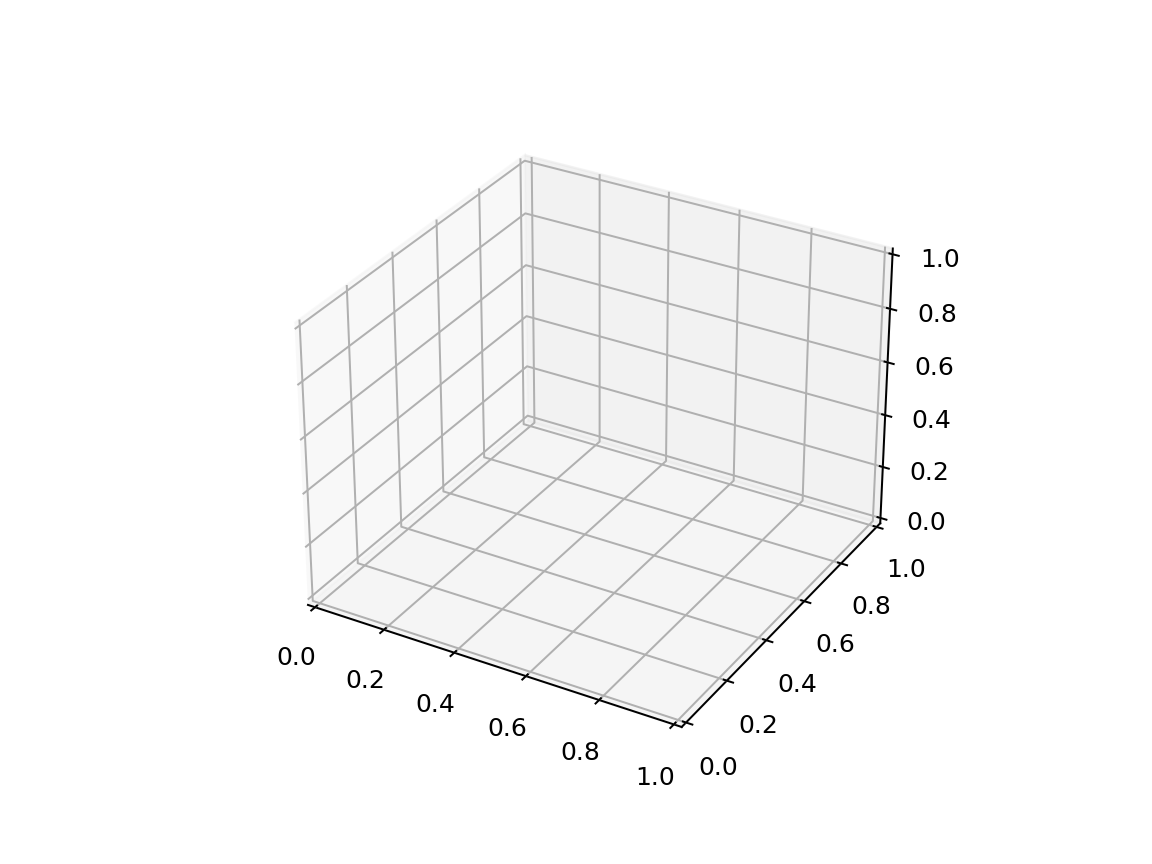

In [11]:
figure = plt.figure(dpi = 180)
ax = figure.add_subplot(projection='3d')

# plot_vectors[...,1] = geom_stl.vectors[...,2]
# plot_vectors[...,2] = geom_stl.vectors[...,1]

# # Load the STL files and add the vectors to the plot
# geom_stl = mesh.Mesh.from_file(f"{geom_path}/open_houses.stl")

# plot_vectors = geom_stl.vectors
# ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# # Auto scale to the mesh size
# scale = geom_stl.points.flatten()
# ax.auto_scale_xyz(scale, scale, scale)
# ax.set_ylim(0, Ly)

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

for p in neighborhood.probes:
    if "col" not in p.name:
        ax.scatter(p.tile[:,0], p.tile[:,1], p.tile[:,2], marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=45, azim=45, roll=0, vertical_axis='y')
# plt.axis('square')

plt.show()

if probe_write: neighborhood.writeProbesToFile(
    f"{scratch_dir}/CHARLES/{category}/R{run}/probes/locations/",
    nameInclude="col")

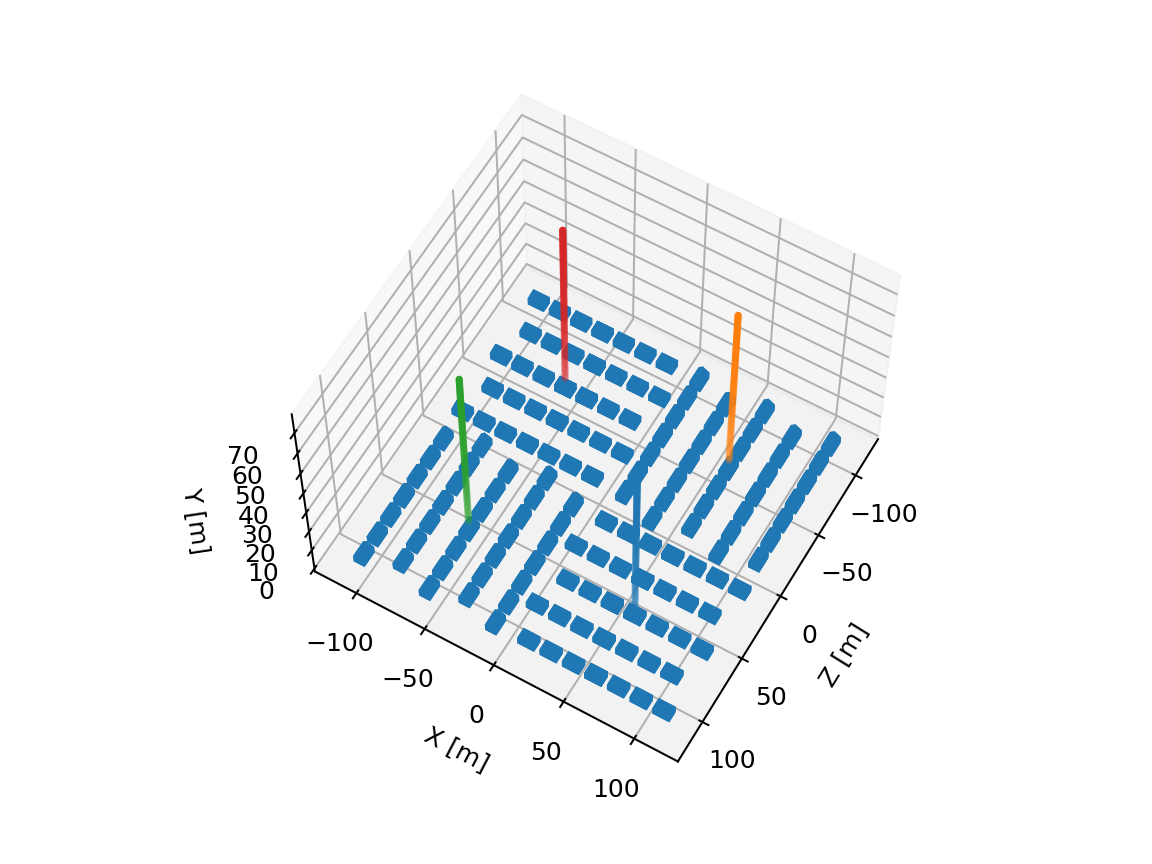

In [ ]:
figure = plt.figure(dpi = 180)
ax = figure.add_subplot(projection='3d')

# plot_vectors[...,1] = geom_stl.vectors[...,2]
# plot_vectors[...,2] = geom_stl.vectors[...,1]

# Load the STL files and add the vectors to the plot
geom_stl = mesh.Mesh.from_file(f"{geom_path}/houses.stl")

plot_vectors = geom_stl.vectors
ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# Auto scale to the mesh size
scale = geom_stl.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)
ax.set_ylim(0, Ly)

for p in neighborhood.probes:
    if "col" in p["name"]:
        ax.scatter(p["tile"][:,0], p["tile"][:,1], p["tile"][:,2], marker="o", lw = 2,  s=(172./figure.dpi)**2, label = p["name"])

# Show the plot to the screen
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')                                                                                                  
ax.view_init(elev=60, azim=30, roll=0, vertical_axis='y')
# plt.legend()
plt.show()

# figure.savefig(f"{geom_path}/houses")

In [ ]:
[house_coordinates[h] for h in interior_house]

[[50.0, 0, 104.0],
 [42.0, 0, 80.0],
 [50.0, 0, 56.0],
 [42.0, 0, 32.0],
 [50.0, 0, 8.0]]

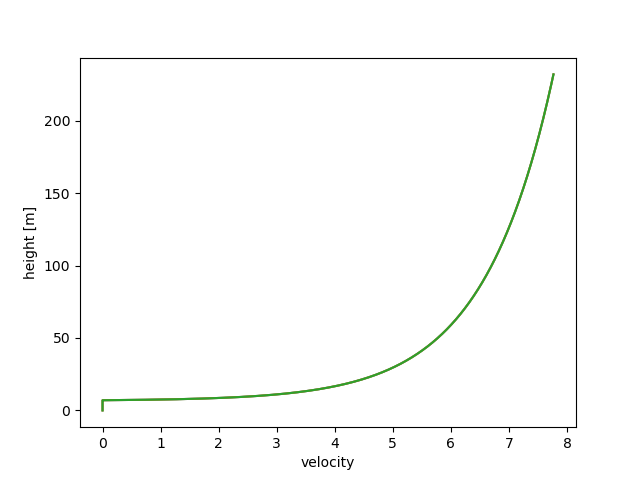

In [ ]:
vK_const = .41
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
z_ref = 10 # really y_ref
U_ref = 4

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)

plt.figure()
LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'Dt': .01,
    'z_values' : np.linspace(0,Lz,10000)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

u_bulk is 6.371350282218943
domain height is 232.0
u_bulk is 6.374655053763201
domain height is 232.0


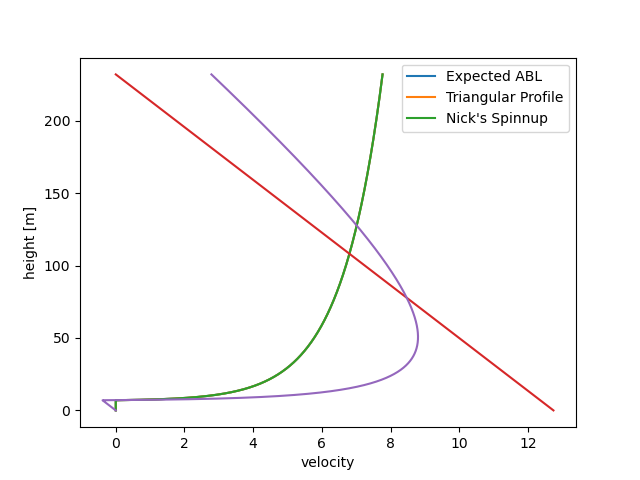

In [ ]:
physics_setup.plot_spinup_velocity()

# physics_setup.LES_params['spinup_profile']

# plt.plot(ux, LES_params['z_values'])

# plt.plot(2*ux - np.flip(spinup_profile), LES_params['z_values'])

physics_setup.plot_spinup_velocity2()

plt.legend(('Expected ABL', 'Triangular Profile', "Nick's Spinnup"))

# plt.plot(ux+2.5*physics_setup.LES_params['uStar'], LES_params['z_values'])

plt.show()


In [ ]:
# For momentum source
y_ref = 0.9 *  Ly
u_t = np.mean(physics_setup.LES_params['log_wind'][physics_setup.LES_params['z_values'] >= y_ref])
display(f"u_t for y_ref = {y_ref} is {u_t}")



'u_t for y_ref = 69.6 is 7.155474717464552'

In [ ]:
wall_spacing = y * (ny + 1) / 10 #physics_setup.LES_params['flatplate']['spacingW']*10
growth_rate = 1.1
a = (growth_rate-1)/growth_rate
level_heights = []
n_levels = -1
total_height = 0

while total_height < Ly:
    level_height = wall_spacing*(2 ** (n_levels))/a
    level_heights.append(level_height)
    total_height += level_height
    n_levels += 1

display(f"Number of refinement levels is {n_levels}") # not counting level 0

hcp_delta = wall_spacing*2**(n_levels)

for level in range(n_levels, 0, -1):
    height = level_heights[n_levels - level]
    if level == n_levels:
        del_height = height
    else:
        del_height = level_heights[n_levels - level + 1] - height
    display(f'Level {level} has height {total_height:f} and spans {height:f}')
    level_hcp_delta = hcp_delta/2**(level)
    display(f'NLAYERS is {del_height/level_hcp_delta}')

display(f'hcp delta is {hcp_delta:f} for wall spacing {wall_spacing:f} and domain height {Ly:f}')

'Number of refinement levels is 4'

'Level 4 has height 102.300000 and spans 3.300000'

'NLAYERS is 5.499999999999996'

'Level 3 has height 102.300000 and spans 6.600000'

'NLAYERS is 5.499999999999996'

'Level 2 has height 102.300000 and spans 13.200000'

'NLAYERS is 5.499999999999996'

'Level 1 has height 102.300000 and spans 26.400000'

'NLAYERS is 5.499999999999996'

'hcp delta is 9.600000 for wall spacing 0.600000 and domain height 77.333333'

In [ ]:
hcp_delta = 19.333
interior_level = n_levels + 3
vol_scale_factor = 1.1
del_interior = hcp_delta / (2 ** interior_level) * vol_scale_factor


# For inclusion in charles.in
print("# For momentum source")
print(f"VOLUMETRIC_PROBE NAME=probes/VolProbe90X \
  INTERVAL=100 GEOM BOX {-Lx/2:f} {Lx/2:f} {y_ref:f} {Ly:f} {-Lz/2:f} {Lz/2:f} \
  VARS=comp(u,0)")
print(f"VOLUMETRIC_PROBE NAME=probes/VolProbe90Z \
  INTERVAL=100 GEOM BOX {-Lx/2:f} {Lx/2:f} {y_ref:f} {Ly:f} {-Lz/2:f} {Lz/2:f} \
  VARS=comp(u,2)")

print("\n# For other volumetric probes")
neighborhood.removeZeroProbes()
for p in neighborhood.probes:
  name = p['name']
  if "col" not in name:
    tile = p["tile"]

    mins = []
    maxs = []
    for i in range(3):
      minLoc = min(tile[:,i])
      maxLoc = max(tile[:,i])
      if (maxLoc - minLoc) < del_interior:
        offset = (del_interior - (maxLoc - minLoc))/2
        minLoc -= offset
        maxLoc += offset
      mins.append(minLoc)
      maxs.append(maxLoc)


    print(f"VOLUMETRIC_PROBE NAME=probes/probesOut/{name:22} \
      INTERVAL=1 GEOM BOX {mins[0]:f} {maxs[0]:f} \
      {mins[1]:f} {maxs[1]:f} \
      {mins[2]:f} {maxs[2]:f} \
      VARS=comp(u,0) comp(u,1) comp(u,2) p")

print("\n# For output Probe files")
for p in neighborhood.probes:
  name = p['name']
  if "col" in name:
    name_txt = f"{p['name']}.txt"
    print(f"PROBE NAME=probes/probesOut/{name:22} INTERVAL=1 GEOM=FILE probes/locations/{name_txt:<26} VARS=comp(u,0) comp(u,1) comp(u,2) p")



# For momentum source
VOLUMETRIC_PROBE NAME=probes/VolProbe90X   INTERVAL=10 GEOM BOX -116.000000 116.000000 69.600000 77.333333 -116.000000 116.000000   VARS=comp(u,0)
VOLUMETRIC_PROBE NAME=probes/VolProbe90Z   INTERVAL=10 GEOM BOX -116.000000 116.000000 69.600000 77.333333 -116.000000 116.000000   VARS=comp(u,2)

# For other volumetric probes
VOLUMETRIC_PROBE NAME=robes/probesOut/xdoor_1-1_sl                 INTERVAL=1 GEOM BOX 41.916929 42.083071       0.375000 2.625000       61.625000 62.375000       VARS=comp(u,0) comp(u,1) comp(u,2) p
VOLUMETRIC_PROBE NAME=robes/probesOut/xwindow_0-0_sl               INTERVAL=1 GEOM BOX 37.918429 38.084571       1.125000 1.875000       57.625000 58.375000       VARS=comp(u,0) comp(u,1) comp(u,2) p
VOLUMETRIC_PROBE NAME=robes/probesOut/zwindow_0-0_sl               INTERVAL=1 GEOM BOX 39.625000 40.375000       1.125000 1.875000       55.918429 56.084571       VARS=comp(u,0) comp(u,1) comp(u,2) p
VOLUMETRIC_PROBE NAME=robes/probesOut/xwindow_0-1_sl 

In [ ]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )

U infinity is 6.364759883965239 with L = 77.33333333333333
flat plate Reynolds number is 33668420.22893784
wall spacing is 0.03473770208614605 for y+ of 500


In [ ]:
# hcp_delta = 9.6
# n_std = 1
# U_ref = physics_setup.LES_params['log_wind']
# U_ref += n_std*(2.5*physics_setup.LES_params['uStar'])
# z_levels = []
# n = 5
# for level in range(n):
#     U_level = U_ref[-1]/(2**level)
#     ind_level = np.argmin(np.abs(U_ref-U_level))
#     z_level = physics_setup.LES_params['z_values'][ind_level]
#     z_levels.append(z_level)

#     display(f'level {level} is at {z_level} with velocity of velocity {U_level}')

# z_levels.append(0)
# for level in range(n):
#     h_level = z_levels[level] - z_levels[level+1]
#     cell_size = hcp_delta/(2**level)
#     h_level = np.max((h_level, 5*cell_size))
#     h_level = np.round(h_level, 0)
#     display(f'level {level} has height of {h_level}')

# display(f'ground mesh size is {cell_size}')

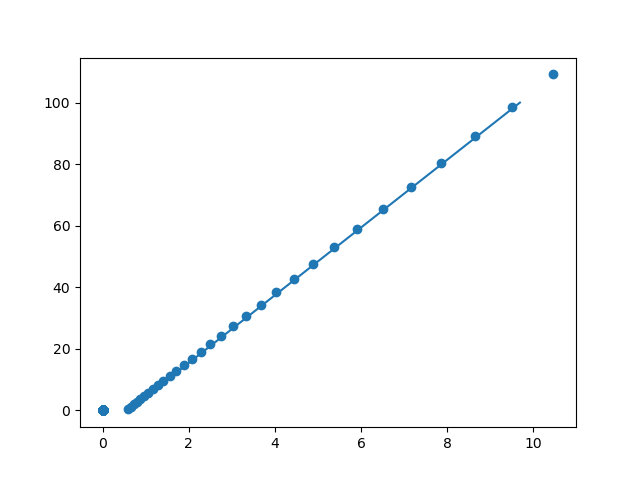

In [ ]:
P0 = 0.6
r = 1.1
y = np.linspace(0, 100, 1000)
s = np.zeros_like(y)
h = np.zeros_like(y)
s[0] = P0
h[0] = P0

h_an = np.zeros_like(y)

for i in range(1, len(y)):
    s[i] = s[i-1]*r
    h[i] = h[i-1] + s[i]
    if h[i] > y[-1]:
        break
plt.figure()
plt.scatter(s,h)
plt.plot(P0+(r-1)/r*y, y)

In [ ]:
# write a function that reads text, looks for three consecutive numbers, and multiplies them by scaling factors
def scale_text(text, scale_factors):
    text = text.split(' ')
    for i in range(len(text)-2):
        try:
            for j in [i, i+1, i+2]:
                float(text[j])
            for j in [i, i+1, i+2]:
                text[j] = float(text[j])
                text[j] *= scale_factors[j-i]
                text[j] =   f'{round(text[j], 1):.1f}'
                text[j] = text[j].replace('.0', '')
        except:
            pass
    text = ' '.join(map(str, text))
    return text

# read text from file and preserve line breaks
with open(f"{scratch_dir}/CHARLES/{category}/R{run}/charles.in", 'r', newline = '') as f:
    text = f.read()
text = scale_text(text, [4/3,1,4/3])
print(text)


RESTART = ../../../STITCH/config2/6M-mesh.mles #./data/result.00085000.sles
# INTERP_FROM_RESTART ../R8/data/result.00080000.sles
# INIT time = 0.0 step = 0 p=0 #u = 10.0 0.0 0.000001
#RESET_ALL
 
#Equation of state
EOS HELMHOLTZ
RHO = 1.225
MU = 1.7894e-5
HELMHOLTZ_SOS 340.65

# Time + output setup
NSTEPS = 100000000
TIMESTEP DT = .01 #.001
CHECK_INTERVAL 100
WRITE_RESULT NAME=data/result INTERVAL=1000

RESET_STATS TIME = 2000
STATS u p rho

# subgrid model
SGS_MODEL VREMAN

#Boundary Conditions
buildings = WM_ALG_WALL 
interior  = WM_ALG_WALL 
ground    = WM_ALG_WALL ROUGHNESS_HEIGHT 0.0032
top       = SLIP

#Temp Boundaries
#top WALL T = -10
#ground WALL T = 10
#interior WALL T = 10
#buildings WALL T = 10

#################################
######### SOLVER SETUP ##########
#################################

# advanced multigrid solver options
MG_AGGLOMERATION_FACTOR 64
MG_SPLIT_ORPHANED_COLORS true
# Momentum equation
# MOMENTUM_MG_NLEVEL 2 # coarse grids + 1 fine grid
MOMENTUM_MG_N